# Iteration Workflow


## To create an updated structure after making new commits:

* Generate an updated network.
* Copy the previous position file to use as a starting point for the next visualization.
* Open Cytoscape or destroy existing collections if Cytoscape is already running.
* Run all cells to load the visualization.
* [Save the new layout if you make changes](http://localhost:8888/notebooks/lein-topology.ipynb#Save-the-updated-layout-coordinates-if-you-make-changes).

## Import common modules

In [1]:
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil
import py2cytoscape.util.cytoscapejs as cyjs
import py2cytoscape.cytoscapejs as renderer

from subprocess import call
from IPython.display import Image

import igraph as igraph
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import sand.io as io
import sand.graph as sg
import sand.cytoscape.positions as scp
import sand.cytoscape.app as app
from sand.cytoscape.themes import ops, colors
from sand.groups import labels_to_groups, namespaces
from sand.matrix import matrix, matrix_frame, show

%matplotlib notebook

<IPython.core.display.Javascript object>

## Load the dataset as a weighted edge list

In [2]:
network_collection = "lein-topology"
network_name = "57af741"

data_path = "./data/" + network_collection + "-" + network_name

In [3]:
edge_file = data_path + ".csv"
edgelist = io.csv_to_dicts(edge_file,header=['source', 'target', 'weight'])
g = sg.edgelist_to_igraph(edgelist)
g.summary()

'IGRAPH DNW- 107 206 -- \n+ attr: indegree (v), label (v), name (v), outdegree (v), weight (e)'

## Is the graph simple?

A graph is simple if it does not have multiple edges between vertices and has no loops, i.e. an edge with the same source and target vertex.

A graph that isn't simple can cause problems for some network analytics algorithms.

In [4]:
g.is_simple()

True

## Community Detection / Clustering

Namespaces are the modules of the system and will serve as groups / communities in the visualization.

In [5]:
g.vs['group'] = labels_to_groups(g.vs['label'])
g.vs['namespace'] = namespaces(g.vs['label'])

## Degree Centrality

Identify the nodes with highest outdegree and indegree.

In [6]:
degree, count = zip(*[(bin_left_side, bin_count) for bin_left_side, bin_right_side, bin_count in g.degree_distribution().bins()])

<IPython.core.display.Javascript object>


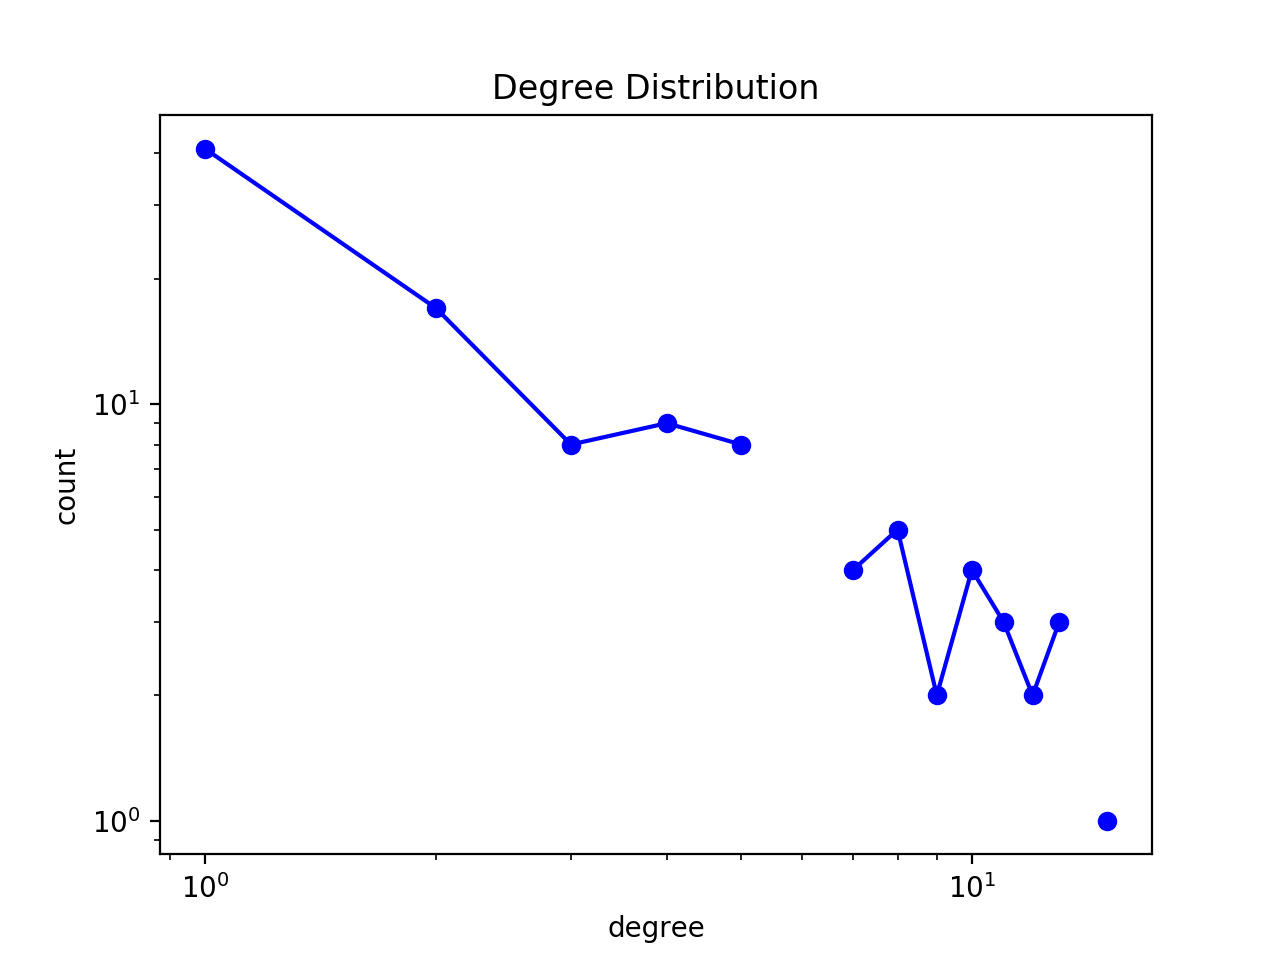

In [7]:
plt.title("Degree Distribution")
plt.ylabel("count")
plt.xlabel("degree")
infig, = plt.loglog(degree, count, 'b-', marker='o')

Which vertices have a degree of more than some majority percentage of the maxdegree?

In [8]:
g.maxdegree(mode='IN')

13

In [9]:
g.maxdegree(mode='OUT')

15

In [10]:
score = g.maxdegree() * .80

In [11]:
score

12.0

Outdegree represents the vertices that have the most dependencies, i.e. call the most number of functions. These functions could potentially be simplified:

In [12]:
[v['name'] for v in g.vs.select(lambda vertex: vertex['outdegree'] >= score)]

['topology.dependencies/dependencies',
 'topology.edgelist-test/syntax-quotes-add-seq-concat-list',
 'topology.dependencies-test/should-compute-fn-calls-in-namespace',
 'leiningen.topology/topology']

Indegree represents the vertices are depended on the most...changing them will have the most impact on other parts of the system:

In [13]:
[v['name'] for v in g.vs.select(lambda vertex: vertex['indegree'] >= 4)]

['clojure.core/defn-',
 'clojure.core/filter',
 'clojure.core/defn',
 'clojure.core/seq',
 'clojure.core/fn',
 'clojure.core/meta',
 'clojure.core/=',
 'clojure.test/is',
 'clojure.core/symbol',
 'clojure.test/deftest',
 'clojure.core/->>',
 'clojure.core/range',
 'clojure.core/map',
 'clojure.core/list']

In this case, `clojure.core` and `clojure.test` namespaces have the most dependencies...not surprising, really. These are good candidates to filter out of a visualization, since they don't add deep insight to the design of the program and might indicate a backplane.

## Extract the subgraph of local namespaces 

There are some analyses where it will be useful to see all the vertices. For the high-level architecture diagram, we can focus on the functions local to the library's namespaces. We'll also keep functions that have side-effects to see if these are isolated to only a few key parts of the program:

In [14]:
# List all patterns of vertex names that we want to keep:
names_to_keep = ('topology', 'clojure.core/*err*', 'clojure.core/println')

lv = g.vs(lambda v: any(match in v['label'] for match in names_to_keep))
lg = g.subgraph(lv)

# Recompute degree after building the subgraph:
lg.vs['indegree'] = lg.degree(mode="in")
lg.vs['outdegree'] = lg.degree(mode="out")

lg.summary()

'IGRAPH DNW- 26 26 -- \n+ attr: group (v), indegree (v), label (v), name (v), namespace (v), outdegree (v), weight (e)'

# Visualizing the network in Cytoscape

## Verify that Cytoscape is running and get the current version

In [15]:
app.print_version()

{
  "apiVersion": "v1",
  "cytoscapeVersion": "3.4.0"
}


## Load into Cytoscape with a default layout

In [16]:
# Create py2cytoscape client
cy = CyRestClient()

In [17]:
# Optional: delete all existing networks
cy.session.delete()

In [18]:
# Load the network
network = cy.network.create_from_igraph(lg, name=network_name, collection=network_collection)

## Customize the style

Use one of the included themes, or build your own.

In [19]:
style = cy.style.create('Ops')
style.update_defaults(ops.settings)

# Map the label property in the igraph data to Cytoscape's NODE_LABEL visual property
style.create_passthrough_mapping(column='label', vp='NODE_LABEL', col_type='String')

### Give each group a unique color.

In [20]:
border_colors = {
  'topology.finder': colors.BRIGHT_YELLOW,
  'topology.dependencies': colors.BRIGHT_ORANGE,
  'topology.dependencies-test': colors.BRIGHT_ORANGE,
  'topology.qualifier': colors.BRIGHT_PURPLE,
  'topology.symbols': colors.BRIGHT_BLUE,
  'clojure.core': colors.BRIGHT_RED,
  'topology.printer': colors.BRIGHT_RED,
  'leiningen.topology': colors.BRIGHT_WHITE,
}

fill_colors = {
  'topology.finder': colors.DARK_YELLOW,
  'topology.dependencies': colors.DARK_ORANGE,
  'topology.dependencies-test': colors.DARK_ORANGE,
  'topology.qualifier': colors.DARK_PURPLE,
  'topology.symbols': colors.DARK_BLUE,
  'clojure.core': colors.DARK_RED,
  'topology.printer': colors.DARK_RED,
  'leiningen.topology': colors.DARK_WHITE,
}

style.create_discrete_mapping(column='namespace', col_type='String', vp='NODE_FILL_COLOR', mappings=fill_colors)
style.create_discrete_mapping(column='namespace', col_type='String', vp='NODE_BORDER_PAINT', mappings=border_colors)

In [21]:
cy.style.apply(style, network)

## Layout

In [22]:
# Apply default layout
cy.layout.apply(name='force-directed', network=network)

In [23]:
# Load layout coordinates from a previous session
positions_file = data_path + "-positions.csv"
scp.layout_from_positions_csv(network, positions_file, cy)

## Save the updated layout coordinates if you make changes

One benefit of this workflow is the ability to manually tweak the algorithmic network layout in Cytoscape.

After making changes, save the coordinates for a later session:

In [24]:
scp.positions_to_csv(network=network, path=positions_file)

## Generate an SVG export

Position the network in Cytoscape the way you want it, then trigger this export.
When iterating, run all cells above, then all cells below this point to avoid race conditions with cytoscape's renderer.

In [25]:
# Hide all panels in the UI
app.hide_panels()

True

In [26]:
# Fit to the window:
cy.layout.fit(network=network)

In [27]:
view_id = network.get_views()[0]

In [28]:
view = network.get_view(view_id=view_id, format='view')

In [29]:
# Zoom out slightly:
view.update_network_view('NETWORK_SCALE_FACTOR', 0.7)

In [30]:
# Shift the network to the left:
view.update_network_view('NETWORK_CENTER_X_LOCATION', 750.0)

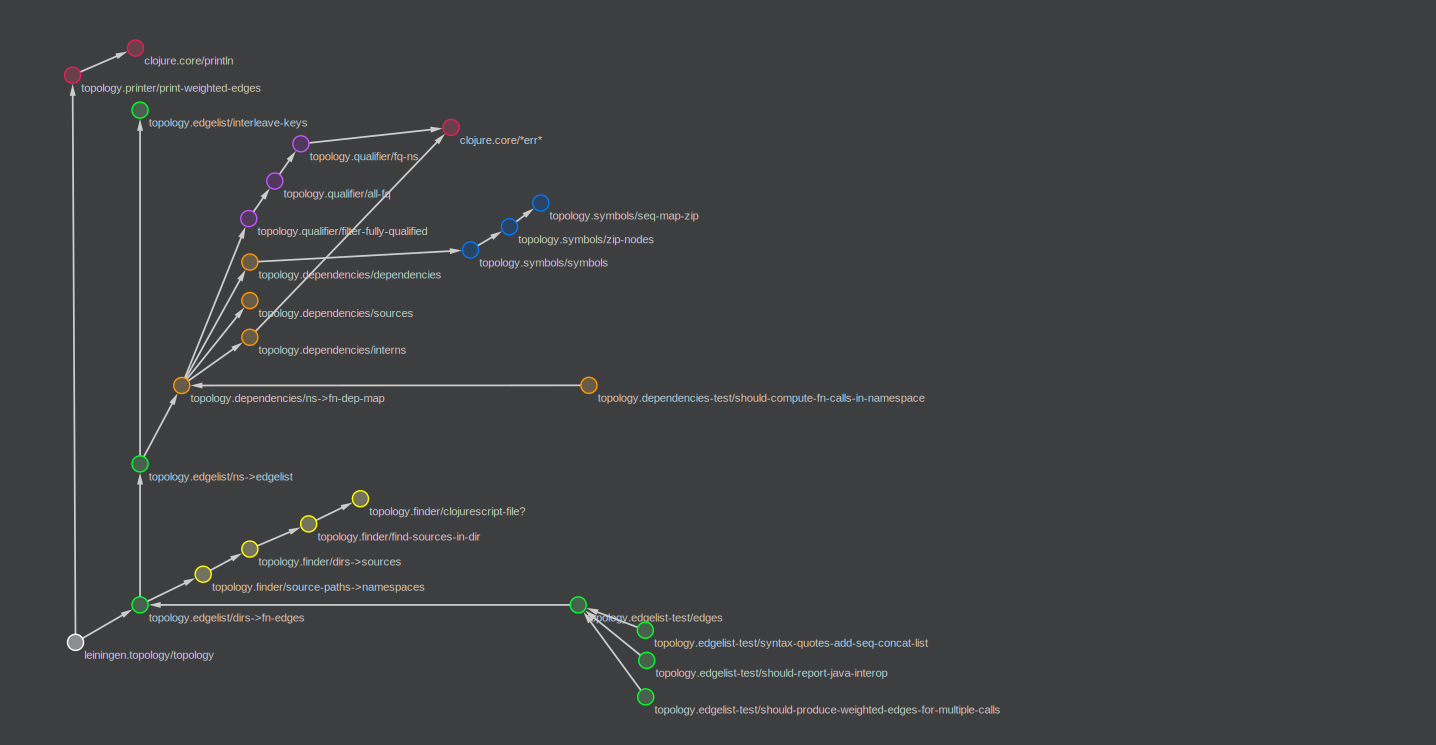

In [31]:
from IPython.display import SVG, display

svg_data = network.get_svg()
display(SVG(svg_data))

In [32]:
# Write the svg to a file if everything looks good:
with open(data_path + '.svg', 'wb') as f:
    f.write(svg_data)

# Visualizing the network with a Dependency Structure Matrix (DSM)

Each row shows a function's dependencies.
Each column shows callers impacted by the function.
This follows the IR/FAD DSM convention.

p.138 of the DSM book has a good description of IR/FAD vs. IC/FBD.

Ordering by group / modules gives us a read on how well the system accomplishes the goal of loosely coupled and highly cohesive modules.

In [33]:
description = """
Each row shows a function's dependencies.
Each column shows callers impacted by the function.
Color depicts group membership. Darker cells indicate a larger number of interactions.
"""
title = "{}-{}".format(network_collection, network_name)
link = matrix(lg, description=description, title=title, scale=800)[1]
matrix_frame(link, scale=400)

In [34]:
show(link)

A more comprehensive introduction to DSM in Sandbook is coming Summer 2017.